# Fit One Cycle

## Resources
- [The 1cycle Policy Sylvain Gugger](https://sgugger.github.io/the-1cycle-policy.html)
- [FastAI Docs fitonecycle](https://docs.fast.ai/callbacks.one_cycle.html)
- [1cycle-learning-rate-policy](https://iconof.com/1cycle-learning-rate-policy/)

## The Problem of Learning Rates

One method *learning rate scheduling* gradually decreases the learning rate until training concludes. This does method does not take into account the error surface during gradient descent.

Another method *adaptive learning rate schedules* modify the weight update process to adjust the learning rate based on the dynamics of the error surface. 3. says that this is computationally expensive, but I don't see how that could be (more research)

__Cyclical Learning Rates__ *this method lets the learning rate cyclically vary between reasonable boundary values. Training with cyclical learning rates instead of fixed values achieves improved classification accuracy without a need to tune and often in fewer iterations* [paper abstract](https://arxiv.org/abs/1506.01186)

### Finding reasonable bounds

__LR range test__ essentially just train the model for a few epochs while gradually increasing the learning rate. Weight for the model to diverge.

## One Cycle Learning

__Super Convergence__ [paper](https://arxiv.org/abs/1708.07120) NNs train faster with one learning rate cycle and a large maximum learning rate.  
*The cycle’s size must be smaller than the total number of iterations/epochs. After the cycle is complete, for the remaining iteration/epochs learning rate should decrease even further, several orders of magnitude less than its initial value. Smith named this the 1cycle policy.*[*](https://iconof.com/1cycle-learning-rate-policy/)

__Momentum__ *To accompany the movement toward larger learning rates, Leslie found in his experiments that decreasing the momentum led to better results. This supports the intuition that in that part of the training, we want the SGD to quickly go in new directions to find a flatter area, so the new gradients need to be given more weight. In practice, he recommends to pick two values likes 0.85 and 0.95, and decrease from the higher one to the lower one when we increase the learning rate, then go back to the higher momentum as the learning rate goes down.*[*](https://sgugger.github.io/the-1cycle-policy.html)

__Learning Rate Finder__ * That's why when we run the Learning Rate Finder, it's very important to use it with the exact same conditions as during our training. For instance different batch sizes or weight decays will impact the results*[*](https://sgugger.github.io/the-1cycle-policy.html)

__1cycle Regularization__ *Training with the 1cycle policy at high learning rates is a method of regularization in itself, so we shouldn't be surprised if we have to reduce the other forms of regularization we were previously using when we put it in place. It will however be more efficient, since we can train for a long time at large learning rates.*[*](https://sgugger.github.io/the-1cycle-policy.html)

# TensorFlow Implementation


## Learning Rate Finder

*Over an epoch begin your SGD with a very low learning rate (like 10−8) but change it (by multiplying it by a certain factor for instance) at each mini-batch until it reaches a very high value (like 1 or 10). Record the loss each time at each iteration and once you're finished, plot those losses against the learning rate.* [*](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)

*the learning rate that corresponds to the minimum value is already a bit too high, since we are at the edge between improving and getting all over the place. We want to go one order of magnitude before, a value that's still aggressive (so that we train quickly) but still on the safe side from an explosion.*[*](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html)

__Modifications__
1. Smooth the recorder losses for each minibatch with exponentially weighted averages. $avg loss_{i} = \beta*avg loss_{i-1} + (1-\beta)*loss_{i}$ $\beta$ between 0 and 1. Close to 1 means smoother. Plot the following 
$smoothed loss_{i}=\frac{avg loss_{i}}{1-\beta^{i+1}}$
2. Stopping criteria... $smoothed loss_i>4*min smoothed loss$
3. lr step increase - at each step $lr_i=lr_0*q^i$ where $q=(\frac{lr_{N-1}}{lr_0})^{\frac{1}{N-1}}$

In [1]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import math

print(tf.__version__)

2.1.0


In [2]:
class find_lr(Callback):
    """
    Modified from https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html
    
    Prograsses through a single epoch, increasing the learning rate until the 
    NN diverges. should be run in the same conditions as training (same batch size)
    
    The max_lr should be one order of magnitude smaller than the graph minimum.
    """
    def __init__(self, num_batches,  init_value = 1e-6, final_value=10., beta = 0.98):
        self.init_value = init_value
        self.final_value = final_value
        self.beta = beta
        self.q = (final_value / init_value) ** (1/(num_batches-1)) #l.r. multiplier: see formula above. 
        self.avg_loss = 0.
        self.best_loss = 0.
        self.batch_num = 0
        self.losses = []
        self.log_lrs = []
        
    def on_train_begin(self, logs={}):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.init_value)
         
    def on_batch_end(self, batch, logs=None):
        logs = logs or {}
        self.batch_num += 1
        lr = K.get_value(self.model.optimizer.lr)
        
        #Compute the smoothed loss
        self.avg_loss = self.beta * self.avg_loss + (1-self.beta) * logs['loss']
        smoothed_loss = self.avg_loss / (1 - self.beta**self.batch_num)

        #Stop if the loss is exploding
        if self.batch_num > 1 and smoothed_loss > 4 * self.best_loss:
            return self.log_lrs, self.losses

        #Record the best loss
        if smoothed_loss < self.best_loss or self.batch_num==1:
            self.best_loss = smoothed_loss

        #Store the values
        self.losses.append(smoothed_loss)
        self.log_lrs.append(math.log10(lr))
        
        #increase the lr 
        K.set_value(self.model.optimizer.lr, lr * self.q )
        
    def plot_lr(self):
        plt.xlabel('L.R. (log_10)')
        plt.ylabel('Loss')
        plt.plot(self.log_lrs, self.losses)  

        locs, labels = plt.xticks()
        for i, lab in enumerate(labels):
            labels[i] = "1e{}".format(str(int(locs[i])))
        plt.xticks(locs, labels)
        plt.xlim(-6,1)
        plt.show()

# Implementation Test

https://github.com/nathanhubens/KerasOneCycle/blob/master/OneCycle.ipynb

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

num_classes = 10
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print(x_train.shape)
print(y_train.shape)

60000 train samples
10000 test samples
(60000, 28, 28, 1)
(60000, 10)


In [4]:
input_shape = (28, 28, 1)
def Net():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, kernel_size=(3,3), 
                               activation='relu', input_shape = input_shape),
        tf.keras.layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
        tf.keras.layers.MaxPool2D(pool_size=(3,3)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(loss = tf.keras.losses.categorical_crossentropy,
                 optimizer = tf.keras.optimizers.SGD(),
                 metrics=['acc'])
    return model

In [5]:
bs = 128
model = Net()
cb = find_lr(x_train.shape[0]/bs)
hist = model.fit(x_train, y_train, batch_size=bs, epochs=1, callbacks=[cb])

Train on 60000 samples
60000/60000 [==============================] - 6s 96us/sample - loss: 2.1750 - acc: 0.2073


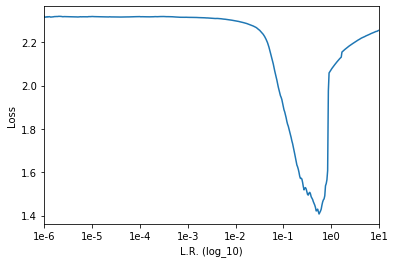

In [6]:
cb.plot_lr()

In [7]:
#####################
##### OneCycle  #####
#https://github.com/nathanhubens/KerasOneCycle/blob/master/utils/keras_OneCycle.py
#####################

          
class OneCycle(Callback):
    """This callback implements a cyclical learning rate and momentum policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration 
    For more detail, please see paper.
    
    # Example
        ```python
            clr = OneCycle(min_lr=1e-3, max_lr=1e-2,
                      min_mtm=0.85, max_mtm=0.95,
                      annealing=0.1,step_size=np.ceil((X_train.shape[0]*epochs/batch_size)))
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    
    # Arguments
        min_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - min_lr).
        step_size: number of training iterations in the cycle. To define as `np.ceil((X_train.shape[0]*epochs/batch_size))`
        max_mtm : initial value of the momentum    
        min_mtm : lower boundary in the cycle.
        annealing_stage : percentage of the iterations where the lr
                    will decrease lower than its min_lr
        annealing_rate : in annealing phase learning rate will be decreased to annealing_rate*min_lr
                    
        # References
        Original paper: https://arxiv.org/pdf/1803.09820.pdf
        Inspired by : https://sgugger.github.io/the-1cycle-policy.html#the-1cycle-policy
    """

    def __init__(self, min_lr=1e-5, max_lr=1e-2, min_mtm = 0.85, max_mtm=0.95, training_iterations=1000.,
                 annealing_stage=0.1, annealing_rate=0.01):

        self.min_lr = min_lr
        self.max_lr = max_lr
        self.min_mtm = min_mtm
        self.max_mtm = max_mtm
        self.annealing_stage = annealing_stage
        self.step_size = training_iterations*(1-self.annealing_stage)/2
        self.min_annealing_lr = annealing_rate * min_lr
        self.iterations = 0.
        self.training_iterations = training_iterations
        self.history = {}
        
    def clr(self):
        if self.iterations < 2*self.step_size :
            x = np.abs(self.iterations/self.step_size - 1)
            return self.min_lr + (self.max_lr-self.min_lr)*(1-x)
        else:
            x = min(1, float(self.iterations - 2 * self.step_size) / (self.training_iterations - 2 * self.step_size))
            return self.min_lr - (self.min_lr - self.min_annealing_lr) * x
        
    
    def cmtm(self):
        if self.iterations < 2*self.step_size :   
            x = np.abs(self.iterations/self.step_size - 1)
        else: 
            x=1
        return self.min_mtm + (self.max_mtm-self.min_mtm)*(x)     
        
    def on_train_begin(self, logs={}):
        if not hasattr(self.model.optimizer, 'lr'):
            raise ValueError('Optimizer must have a "lr" attribute.')
        logs = logs or {}
        K.set_value(self.model.optimizer.lr, self.min_lr)
        K.set_value(self.model.optimizer.momentum, self.max_mtm)
         
    def on_batch_end(self, batch, logs=None):
        
        logs = logs or {}
        self.iterations += 1
    
        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('momentum', []).append(K.get_value(self.model.optimizer.momentum))
        self.history.setdefault('iterations', []).append(self.iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        #increase/decrease the lr and momentum
        K.set_value(self.model.optimizer.lr, self.clr()) 
        K.set_value(self.model.optimizer.momentum, self.cmtm())
        
    def plot_lr(self):
        plt.xlabel('Training Iterations')
        plt.ylabel('Learning Rate')
        plt.title("CLR - '1 cycle' Policy")
        plt.plot(self.history['iterations'], self.history['lr'])
        
    def plot_mtm(self):
        plt.xlabel('Training Iterations')
        plt.ylabel('Momentum')
        plt.title("CLR - '1 cycle' Policy")
        plt.plot(self.history['iterations'], self.history['momentum'])

In [8]:
bs = 128
model = Net()
cb = OneCycle(min_lr=1e-2,max_lr=1e-1)
hist = model.fit(x_train, y_train, validation_data=(x_test,y_test), 
                 batch_size=bs, epochs=1, callbacks=[cb])

Train on 60000 samples, validate on 10000 samples
60000/60000 [==============================] - 5s 87us/sample - loss: 0.7941 - acc: 0.7475 - val_loss: 0.1934 - val_acc: 0.9424


In [12]:
hist.history

{'loss': [0.7941481598695119],
 'acc': [0.7475],
 'val_loss': [0.19344778183698655],
 'val_acc': [0.9424]}